# Corrupted labels are a useful way to measure a networks generalization potential
- https://arxiv.org/pdf/1611.03530.pdf

In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src.data_loader import Shifted_Data_Loader,upsample_dataset
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import GResNet,EDense
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist,mnist
from keras.layers import Dense
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import adadelta

# from tabulate import tabulate

Using TensorFlow backend.


In [2]:
config,_ = get_config()
# Boilerplate
setattr(config, 'proj_root', '/home/elijahc/projects/vae')
setattr(config, 'log_dir', '/home/elijahc/projects/vae/logs')
setattr(config, 'dev_mode',False)
setattr(config, 'seed', 7)
setattr(config, 'project','vae')
setattr(config, 'ecc_max',0.8)

# Architecture Params
setattr(config, 'enc_layers', [3000,2000])
setattr(config, 'dec_blocks', [4,2,1])
setattr(config, 'z_dim', 5)
setattr(config, 'y_dim', 10)

# Training Params
setattr(config, 'batch_size', 512)
setattr(config, 'dataset', 'fashion_mnist')
setattr(config, 'epochs',150)
setattr(config, 'monitor', None)
# setattr(config, 'lr', 10)
# setattr(config, 'min_delta', 0.5)
setattr(config, 'optimizer', 'nadam')
setattr(config, 'label_corruption',0.0)

if config.ecc_max == 0.:
    
    translation_amt = None
else:
    translation_amt = config.ecc_max


# Loss Weights
setattr(config, 'xcov', 0)
setattr(config, 'recon', 0)
setattr(config, 'xent', 15)
setattr(config,'model_dir','/home/elijahc/projects/vae/models/2019-05-01/recon_{}_ecc_{}/label_corruption_{}'.format(config.recon,config.ecc_max,config.label_corruption))




In [3]:
np.random.seed(7)
if not config.dev_mode:
    print('setting up...')
    prepare_dirs_and_logger(config)
    
vars(config)


setting up...
/home/elijahc/projects/vae/models/2019-05-01/recon_0_ecc_0.8/label_corruption_0.0  does not exist...
creating...
/home/elijahc/projects/vae/logs/0502_053434_fashion_mnist  does not exist...
creating...


{'batch_size': 512,
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'dev_mode': False,
 'ecc_max': 0.8,
 'enc_layers': [3000, 2000],
 'epochs': 150,
 'label_corruption': 0.0,
 'log_dir': '/home/elijahc/projects/vae/logs',
 'log_level': 'INFO',
 'model_dir': '/home/elijahc/projects/vae/models/2019-05-01/recon_0_ecc_0.8/label_corruption_0.0',
 'model_name': '0502_053434_fashion_mnist',
 'monitor': None,
 'optimizer': 'nadam',
 'proj_root': '/home/elijahc/projects/vae',
 'project': 'vae',
 'recon': 0,
 'run_dir': '/home/elijahc/projects/vae/logs/0502_053434_fashion_mnist',
 'seed': 7,
 'xcov': 0,
 'xent': 15,
 'y_dim': 10,
 'z_dim': 5}

In [4]:
DL = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
                         translation=translation_amt,num_train=180000,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.8
rot_max:  None
bg_noise: None
loading fashion_mnist...
sx_train:  (180000, 3136)
making training data...
making testing data...


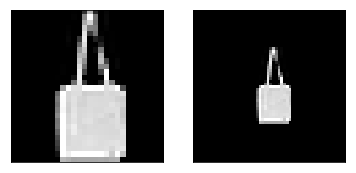

In [5]:
pt,idx = plot_ovt(DL,cmap='gray')

In [6]:
G_builder = GResNet(y_dim=config.y_dim,z_dim=config.z_dim,dec_blocks=config.dec_blocks)
E_builder = EDense(enc_layers=config.enc_layers,z_dim=config.z_dim,)
trainer = Trainer(config,DL,E_builder,G_builder,)
# setattr(trainer.config,'model_dir','/home/elijahc/projects/vae/models/2019-01-22/')

building encoder...
building decoder/generator...


In [7]:
trainer.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input_image[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2000)         6002000     dense_1[0][0]                    
__________________________________________________________________________________________________
enc_merge (Dense)               (None, 16)           32016       dense_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [8]:
# trainer.build_model()
trainer.compile_model()
# trainer.G.summary()

In [9]:
DL.sx_test.shape

(10000, 3136)

In [10]:
val_pct = 0.05
val_idxs = np.random.choice(np.arange(10000),int(val_pct*60000),replace=False)
validation_set = (DL.sx_test[val_idxs],
                  {'class':DL.y_test_oh[val_idxs],
                   'G':DL.sx_test[val_idxs]}
                 )

In [11]:
if config.label_corruption >= 0.1:
    # Load corrupted Labels
    y_tr_corr = np.load('../data/fashion_mnist_corrupted_labels/y_train_{}.npy'.format(config.label_corruption))
    y_tr_corr = upsample_dataset(y_tr_corr,180000-60000)
    y_corr_idxs = np.load('../data/fashion_mnist_corrupted_labels/corrupted_idxs_{}.npy'.format(config.label_corruption))
    y_corr_idxs = np.concatenate([y_corr_idxs,(y_corr_idxs+60000),y_corr_idxs+120000],axis=0)
    y_corrupted_oh = to_categorical(y_tr_corr,num_classes=10)
    y = y_corrupted_oh
    DL.gen_corrupted_shift_image(y_corr_idxs,y_tr_corr)
else:
    y = DL.y_train_oh

In [12]:
trainer.go(x=DL.sx_train,
           y={
               'class':y,
#                'D_real':RF,
               'G':DL.sx_train},
#            validation_split=0.05,
           shuffle=True,
           validation_data=validation_set,
           verbose=0)

Epoch        G_loss      val_G_loss  class_acc   val_class_acc
0:           1207.9695   1159.1305   0.6685      0.7287      
1:           1205.6399   1250.3552   0.7693      0.7543      
2:           1186.6646   1182.1809   0.8026      0.7793      
3:           1182.5743   1195.9126   0.8238      0.7893      
4:           1163.5197   1172.628    0.8387      0.793       
5:           1157.5375   1144.8944   0.8514      0.791       
6:           1136.9996   1124.887    0.8616      0.8027      
7:           1131.581    1121.5891   0.8704      0.805       
8:           1129.2318   1134.9291   0.8795      0.7993      
9:           1113.3091   1106.6077   0.8875      0.8007      
10:          1091.1998   1067.1469   0.8956      0.799       
11:          1091.6072   1067.2146   0.9028      0.807       
12:          1091.6583   1067.1733   0.9086      0.8097      
13:          1090.1985   1107.1326   0.9151      0.802       
14:          1077.8465   1040.2524   0.9212      0.8093      
15:    

In [13]:
DL.sx_train.shape

(180000, 3136)

In [14]:
hist_df = pd.DataFrame.from_records(trainer.model.history.history)
hist_df.head()

,G_loss,G_mse,class_acc,class_loss,loss,val_G_loss,val_G_mse,val_class_acc,val_class_loss,val_loss
0,1207.969487,1207.969487,0.668506,0.904699,13.572168,1159.130463,1159.130463,0.728667,0.700945,10.514196
1,1205.639883,1205.639883,0.769289,0.589984,8.849763,1250.355184,1250.355184,0.754333,0.628158,9.422370
2,1186.664562,1186.664562,0.802550,0.512437,7.686558,1182.180860,1182.180860,0.779333,0.593223,8.898342
3,1182.574263,1182.574263,0.823761,0.459008,6.885126,1195.912620,1195.912620,0.789333,0.596274,8.944104
4,1163.519718,1163.519718,0.838650,0.417962,6.269437,1172.628027,1172.628027,0.793000,0.571769,8.576539


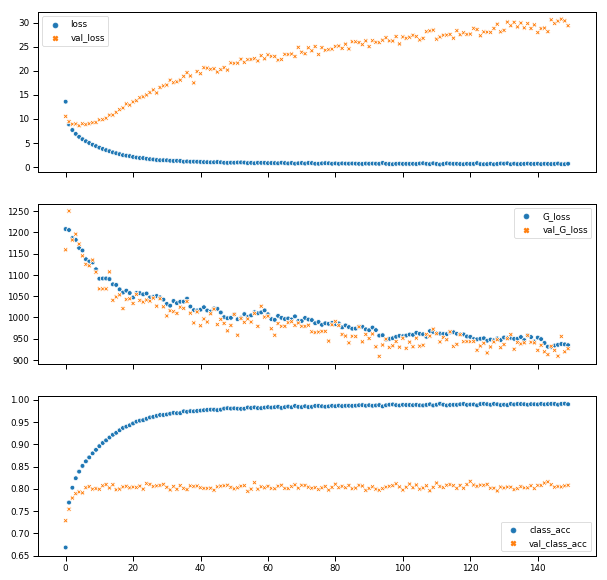

In [15]:
sns.set_context('paper')
metrics = ['loss','G_loss','class_acc']
fig,axs = plt.subplots(nrows=len(metrics),sharex=True,figsize=(10,10))
for metric_name,ax in zip(metrics,axs):
    sns.scatterplot(data=hist_df[[metric_name,'val_'+metric_name]],ax=ax)

In [16]:
hist_df['generalization_error'] = hist_df.val_loss - hist_df.loss
hist_df['G_generalization_error'] = hist_df.val_G_loss - hist_df.G_loss
hist_df['class_generalization_error'] = hist_df.val_class_loss - hist_df.class_loss

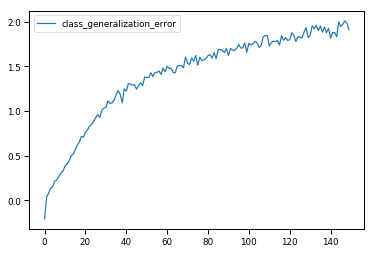

In [17]:
sns.lineplot(data=hist_df[['class_generalization_error']])
# plt.yscale('log')

In [18]:
import datetime as dt
def clean_config(config,keys=['dev_mode','log_dir','log_level','proj_root']):
    c = vars(config)
    for k in keys:
        if k in c.keys():
            del c[k]
    
    c['uploaded_by']='elijahc'
    c['last_updated']= str(dt.datetime.now())
    return c

In [19]:
run_meta = clean_config(config)
run_meta['project']='vae'
# run_meta['ecc_max']=0.8
run_meta

{'batch_size': 512,
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'ecc_max': 0.8,
 'enc_layers': [3000, 2000],
 'epochs': 150,
 'label_corruption': 0.0,
 'last_updated': '2019-05-02 06:35:11.331668',
 'model_dir': '/home/elijahc/projects/vae/models/2019-05-01/recon_0_ecc_0.8/label_corruption_0.0',
 'model_name': '0502_053434_fashion_mnist',
 'monitor': None,
 'optimizer': 'nadam',
 'project': 'vae',
 'recon': 0,
 'run_dir': '/home/elijahc/projects/vae/logs/0502_053434_fashion_mnist',
 'seed': 7,
 'uploaded_by': 'elijahc',
 'xcov': 0,
 'xent': 15,
 'y_dim': 10,
 'z_dim': 5}

In [20]:
trainer.save_model()
run_conf = clean_config(config)

with open(os.path.join(run_conf['model_dir'],'config.json'), 'w') as fp:
    json.dump(run_conf, fp)

hist_df.to_parquet(os.path.join(run_conf['model_dir'],'train_history.parquet'))

In [21]:
generator = trainer.G

In [22]:
trainer.E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input_image[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2000)         6002000     dense_1[0][0]                    
__________________________________________________________________________________________________
enc_merge (Dense)               (None, 16)           32016       dense_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [23]:
trainer.model.get_layer(name='dense_1').output

<tf.Tensor 'dense_1/Relu:0' shape=(?, 3000) dtype=float32>

In [24]:
z_encoder = Model(trainer.input,trainer.z_lat)
classifier = Model(trainer.input,trainer.y_class)

l1_encoder = Model(trainer.input,trainer.model.get_layer(name='dense_1').output)
l2_encoder = Model(trainer.input,trainer.model.get_layer(name='dense_2').output)

In [25]:
mod = trainer.model

In [26]:
mod.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input_image[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2000)         6002000     dense_1[0][0]                    
__________________________________________________________________________________________________
enc_merge (Dense)               (None, 16)           32016       dense_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [27]:
def get_weight_grad(model, inputs, outputs):
    """ Gets gradient of model for given inputs and outputs for all weights"""
    grads = model.optimizer.get_gradients(model.total_loss, model.trainable_weights)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    output_grad = f(x + y + sample_weight)
    return output_grad

In [28]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3000)              9411000   
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              6002000   
_________________________________________________________________
enc_merge (Dense)            (None, 16)                32016     
_________________________________________________________________
lambda_1 (Lambda)            [(None, 10), (None, 5), ( 0         
_________________________________________________________________
class (Activation)           (None, 10)                0         
Total params: 15,445,016
Trainable params: 15,445,016
Non-trainable params: 0
________________________________________________________________

In [29]:
DL.y_test_oh.shape

(10000, 10)

In [30]:
classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
res = classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)
ts_error = 1-res[1]
print(res[1])
df = pd.DataFrame.from_records({'test_acc':[res[1]],
                                'label_corruption':[config.label_corruption],
                                'recon':[config.recon],
                                'xent':[config.xent],
                                'ecc_max':[config.ecc_max],
                                'xcov': [config.xcov]})
df.to_json(os.path.join(config.model_dir,'performance.json'))

10000/10000 [==============================] - 0s 38us/step
0.8112999994277954


In [31]:
l1_enc = l1_encoder.predict(DL.sx_test,batch_size=config.batch_size)
l2_enc = l2_encoder.predict(DL.sx_test,batch_size=config.batch_size)

z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
# y_lat = y_lat_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_enc = classifier.predict(DL.sx_test,batch_size=config.batch_size)

In [32]:
z_enc_tr = z_encoder.predict(DL.sx_train,batch_size=config.batch_size)
# y_lat = y_lat_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_enc_tr = classifier.predict(DL.sx_train,batch_size=config.batch_size)

In [33]:
np.save(os.path.join(config.model_dir,'z_enc'),z_enc)
np.save(os.path.join(config.model_dir,'l1_enc'),l1_enc)
np.save(os.path.join(config.model_dir,'l2_enc'),l2_enc)
np.save(os.path.join(config.model_dir,'y_enc'),y_enc)

In [34]:
l2_enc.shape

(10000, 2000)

In [35]:
_lat_vec = np.concatenate([y_enc,z_enc],axis=1)
_lat_vec.shape

(10000, 15)

In [36]:
z_enc_mu = np.mean(z_enc,axis=0)
z_enc_cov = np.cov(z_enc,rowvar=False)

In [37]:
np.random.multivariate_normal(z_enc_mu,z_enc_cov,size=50).shape

(50, 5)

In [38]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

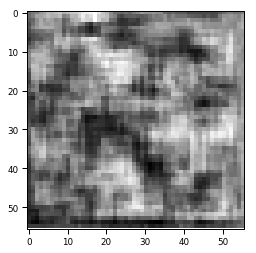

In [39]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [40]:
_lat_vec[rand_im]

array([ 9.7695774e-16,  7.5645145e-14,  9.9999976e-01,  2.4054277e-29,
        2.0444951e-07,  2.7131015e-30,  1.9041111e-09,  0.0000000e+00,
        2.1444328e-21,  0.0000000e+00,  8.3131021e-01,  2.4925814e+00,
        4.0891337e-01, -1.0593295e-01,  2.5228941e+00], dtype=float32)

In [41]:
DL2 = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
                         translation=translation_amt,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.8
rot_max:  None
bg_noise: None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...


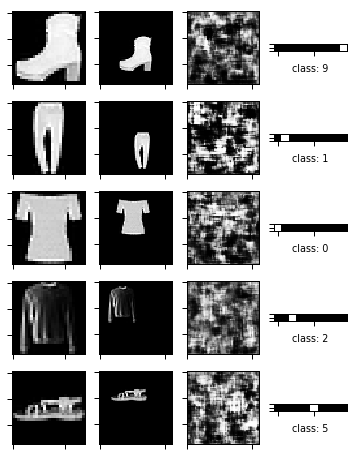

In [42]:
enc_dec_samples(DL.x_train,DL.sx_train,z_enc_tr,y_enc_tr,generator)

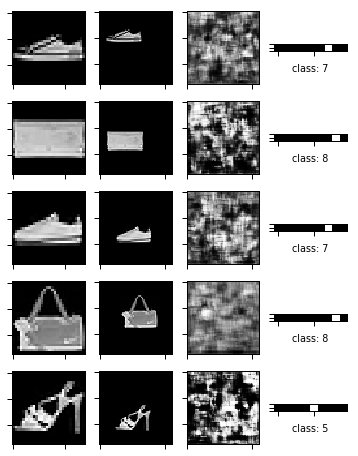

In [43]:
enc_dec_samples(DL.x_test,DL.sx_test,z_enc,y_enc,generator)

In [44]:
z_enc2 = z_encoder.predict(DL2.sx_test,batch_size=config.batch_size)
y_lat2 = classifier.predict(DL2.sx_test,batch_size=config.batch_size)
_lat_vec2 = np.concatenate([y_lat2,z_enc2],axis=1)
regen2 = generator.predict(_lat_vec2,batch_size=config.batch_size)

In [45]:
from src.plot import remove_axes,remove_labels
from src.utils import gen_trajectory

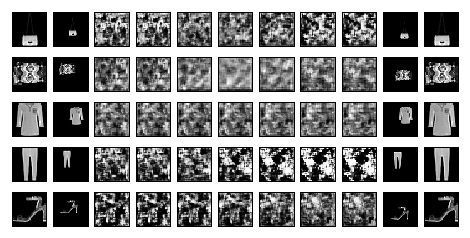

In [46]:
examples = 5
rand_im = np.random.randint(0,10000,size=examples)
fix,axs = plt.subplots(examples,11,figsize=(8,4))
_lat_s = []
regen_s = []
out = gen_trajectory(z_enc[rand_im],z_enc2[rand_im],delta=.25)
out_y = gen_trajectory(y_enc[rand_im],y_lat2[rand_im],delta=.25)

for z,y in zip(out,out_y):
    _lat = np.concatenate([y,z],axis=1)
    _lat_s.append(_lat)
    regen_s.append(generator.predict(_lat,batch_size=config.batch_size))

i=0
for axr,idx in zip(axs,rand_im):
    axr[0].imshow(DL.x_test[idx].reshape(28,28),cmap='gray')
    axr[1].imshow(DL.sx_test[idx].reshape(56,56),cmap='gray')
    axr[2].imshow(regen[idx].reshape(56,56),cmap='gray')
    for j,a in enumerate(axr[3:-3]):
        a.imshow(regen_s[j][i,:].reshape(56,56),cmap='gray')
#         a.imshow(s.reshape(56,56),cmap='gray')
    axr[-3].imshow(regen2[idx].reshape(56,56),cmap='gray')
    axr[-2].imshow(DL2.sx_test[idx].reshape(56,56),cmap='gray')
    axr[-1].imshow(DL2.x_test[idx].reshape(28,28),cmap='gray')
    for a in axr:
        remove_axes(a)
        remove_labels(a)
    i+=1
# plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [47]:
# fix.savefig('../../updates/2019-02-05/assets/img/translocate_{}.png'.format(translation_amt))

In [48]:
fdjsakl;fdsa

NameError: name 'fdjsakl' is not defined

In [ ]:
dxs = DL.dx[1]-14
dys = DL.dy[1]-14

In [ ]:
from sklearn.preprocessing import MinMaxScaler

feat_range = (0,30)
z_enc_scaled = [MinMaxScaler(feat_range).fit_transform(z_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(25)]
z_enc_scaled = np.squeeze(np.array(z_enc_scaled,dtype=int))

In [ ]:
l2_enc_scaled = [MinMaxScaler(feat_range).fit_transform(l2_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(2000)]
l2_enc_scaled = np.squeeze(np.array(l2_enc_scaled,dtype=int))

In [ ]:
l2_enc_scaled.shape

In [ ]:
from collections import Counter
import dit
from dit import Distribution

def mutual_information(X,Y):
    XY_c = Counter(zip(X,Y))
    XY_pmf = {k:v/float(sum(XY_c.values())) for k,v in XY_c.items()}
    XY_jdist = Distribution(XY_pmf)
        
    return dit.shannon.mutual_information(XY_jdist,[0],[1])

In [ ]:
z_dx_I = [mutual_information(z_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(25)]
l2_dx_I = [mutual_information(l2_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(2000)]

In [ ]:
z_dy_I = [mutual_information(z_enc_scaled[i],dys.astype(int)+14) for i in np.arange(25)]
l2_dy_I = [mutual_information(l2_enc_scaled[i],dys.astype(int)+14) for i in np.arange(2000)]

In [ ]:
z_class_I = [mutual_information(z_enc_scaled[i],DL.y_test) for i in np.arange(25)]
l2_class_I = [mutual_information(l2_enc_scaled[i],DL.y_test) for i in np.arange(2000)]

In [ ]:
z_I_df = pd.DataFrame.from_records({'class':z_class_I,'dy':z_dy_I,'dx':z_dx_I})
z_I_df['class'] = z_I_df['class'].values.round(decimals=1)

In [ ]:
l2_I_df = pd.DataFrame.from_records({
    'class':l2_class_I,
    'dy':l2_dy_I,
    'dx':l2_dx_I})
l2_I_df['class'] = l2_I_df['class'].values.round(decimals=1)

In [ ]:
l2_I_df.head()

In [ ]:
plt.hist(l2_I_df.dx)

In [ ]:
plt.hist(z_I_df.dx)

In [ ]:
config.translation_amt = translation_amt
config.translation_amt

In [ ]:
dir_path = '../data/xcov_importance/dist_{}/'.format(translation_amt)

z_I_df.to_pickle('../data/xcov_importance/dist_{}/z_mutual_info.pk'.format(translation_amt))
np.save('../data/xcov_importance/dist_{}/dxs'.format(translation_amt), DL.dx[1]-14)
np.save('../data/xcov_importance/dist_{}/dys'.format(translation_amt), DL.dy[1]-14)
np.save('../data/xcov_importance/dist_{}/z_enc'.format(translation_amt), z_enc)

hist_df.to_pickle(os.path.join(dir_path,'training_hist.df'))

with open(os.path.join(dir_path,'config.json'), 'w') as fp:
        json.dump(vars(config), fp)

In [ ]:
def filter_by_weight(wts,thresh=0.01):
    idxs = np.abs(wts)>thresh
    return idxs

In [ ]:
dx_max = np.argmax(z_I_df.dx.values)
dy_max = np.argmax(z_I_df.dy.values)

In [ ]:
t = 0.05
dx_filt = filter_by_weight(z_w_k[:,dx_max],thresh=t)
dy_filt = filter_by_weight(z_w_k[:,dy_max],thresh=t)
union = np.union1d(np.where(dx_filt==True),np.where(dy_filt==True))
intersect = np.intersect1d(np.where(dx_filt==True),np.where(dy_filt==True))
# filt = np.array([False]*2000)
# filt[union] = True

sns.set_context('talk')
fig,axs = plt.subplots(1,2,figsize=(6*2,5))

filt = dy_filt
print('num: ',len(union))
print('intersect_frac: ',float(len(intersect))/len(union))
print('mean dx_I: ',l2_I_df.dx[filt].mean())
print('mean dy_I: ',l2_I_df.dy[filt].mean())
points = axs[0].scatter(x=l2_I_df['dx'],y=l2_I_df['dy'],
                        c=l2_I_df['class'],cmap='viridis',vmin=0,vmax=0.4,s=z_I_df['class']*100
                       )
plt.colorbar(points)
points = axs[1].scatter(x=z_I_df['dx'],y=z_I_df['dy'],c=z_I_df['class'],cmap='viridis',s=z_I_df['class']*100,vmin=0,vmax=0.4)
# plt.colorbar(points)
axs[0].set_ylim(0,0.9)
axs[0].set_xlim(0,0.9)
axs[1].set_ylim(0,0.9)
axs[1].set_xlim(0,0.9)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(z_dx_I,z_dy_I)
# ax.set_ylim(0,0.8)
# ax.set_xlim(0,0.8)

In [ ]:
plt.scatter(np.arange(25),sorted(z_class_I,reverse=True))
# plt.scatter(np.arange(25),z_dx_I)
# plt.scatter(np.arange(25),z_dy_I)

In [ ]:
from src.metrics import var_expl,norm_var_expl
from collections import Counter

dtheta = DL.dtheta[1]
fve_dx = norm_var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = norm_var_expl(features=z_enc,cond=dys,bins=21)
fve_class = norm_var_expl(features=z_enc, cond=DL.y_test, bins=21)
# fve_dt = norm_var_expl(features=z_enc,cond=dtheta,bins=21)

In [ ]:
# fve_dx_norm = (dxs.var()-fve_dx)/dxs.var()
# fve_dy_norm = (dys.var()-fve_dy)/dys.var()
# fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()
fve_dx_norm = fve_dx
fve_dy_norm = fve_dy

In [ ]:
import seaborn as sns
sns.set_context('talk')

In [ ]:
fve_dx_norm.shape
# np.save(os.path.join(config.model_dir,'fve_dx_norm'),fve_dx_norm)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.scatter(fve_dx_norm.mean(axis=0),fve_dy_norm.mean(axis=0))
plt.xlabel('fve_dx')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dx.png'))
# plt.ylim(-0.125,0.25)
xdim = np.argmax(fve_dx_norm.mean(axis=0))

In [ ]:
fve_dy_norm.mean(axis=0)
# np.save(os.path.join(config.model_dir,'fve_dy_norm'),fve_dy_norm)

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dy.png'))
# plt.ylim(-0.125,0.25)
ydim = np.argmax(fve_dy_norm.mean(axis=0))

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_class.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_class')
# plt.ylim(0.0,0.5)
np.argmax(fve_class.mean(axis=0))

In [ ]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[xdim,ydim],dxs)

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],dys)

In [ ]:
Z_color_scatter(z_enc,[7,18],dtheta)

In [ ]:
from plt.